In [67]:
# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

선형회귀 훈련은 정규방정식을 사용하거나 Gradient Descent를 사용하여 최적의 모델 파라미터를 찾아서 비용함수를 최소화

비선형 데이터(다항회귀)는 학습 곡선을 사용하여 Overfitting 방지

분류작업에 널리 쓰이는 로지스틱 회귀와 소프트맥스 회귀

데사스에 회귀쪽 데이터 만들고 하는거 보자!!

## 4.1 Linear regression

### 4.1 Linear regression using the Normal Equation

Normal Equation
$$w = (X^T\cdot{X})^{-1}\cdot{X^T}\cdot{y}$$

In [19]:
# 임의의 회귀 데이터 생성
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

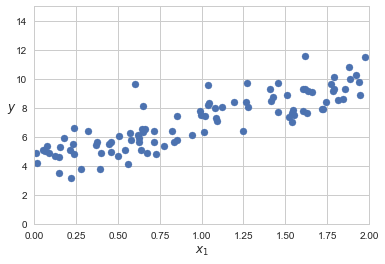

In [20]:
plt.scatter(X, y)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.axis([0, 2, 0, 15])
plt.show()

In [21]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [22]:
theta_best

array([[4.34332876],
       [2.77624352]])

**Observe:**
* 정규방정식을 통해 구해 낸 $\theta_0$ = 3.87, $\theta_1$ = 3.18
* 실제는 $\theta_0$ = 4, $\theta_1$ = 3

In [23]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance

y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.34332876],
       [9.89581579]])

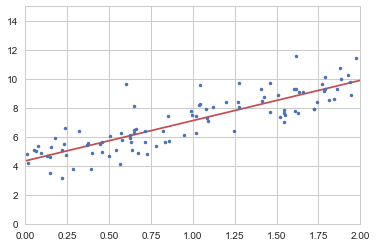

In [24]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

위의 과정을 사이킷런을 활용하면 아래와 같다

In [25]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.34332876]), array([[2.77624352]]))

In [26]:
lin_reg.predict(X_new)

array([[4.34332876],
       [9.89581579]])

## 4.2 Gradient Descent

### 4.2.1 Batch Gradient Descent

$x_{k+1} = x_{k} - u\triangledown g(x_k)$

경사 하강법의 가장 중요한 파라미터는 스텝($u$)의 크기, learning rate 하이퍼파라미터로 결정

경사하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 한다.

매 스텝에서 훈련 데이터 전체를 사용한다. 그래서 Batch(일괄) Gradient Descent

In [13]:
eta = 0.1 #learning rate / step size
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
theta

array([[3.92518763],
       [3.25064506]])

In [15]:
X_new_b.dot(theta)

array([[ 3.92518763],
       [10.42647774]])

In [16]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations =1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

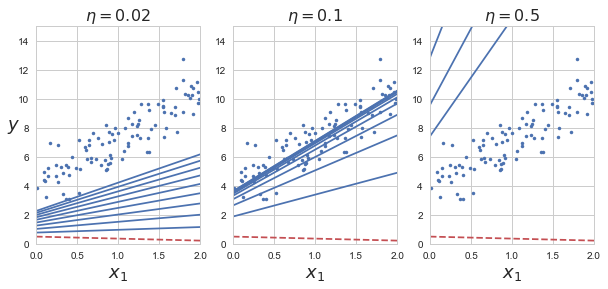

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

### 4.2.2 Stochastic Gradient Descent

배치 경사 하강법의 가장 큰 문제는 매 스텝에서 전체 훈련 세트 사용해서 그래디언트를 계산하기 때문에 훈련세트가 크다면 매우 느려지게 된다.

* 장점
  - 계산이 빠르다 : 확률적 경사 하강법은 매 스텝에서 딱 한개의 샘플을 무작위로 선택하고 그 샘플에 대한 그래디언트를 계산.
  - 불규친한 알고리즘이 오히려 지역 최솟값을 뛰어 넘을 수 있도록 도와줘서 전역최솟값을 찾을 가능성이 더 높다.

* 단점
  - 확률적(무작위) 샘플링이기 때문에 불안정 : 부드럽게 최솟값에 다다르는 것이 아니라 위 아래로 요동치면서 평균적으로 감소.
  - 전역 최솟값에 다다르지 못할 수 도 있다.
  
이러한 트레이드 오프를 학습률을 점전적으로 감소시키는 것으로 해결
시작할 때는 학습률을 크게 해서 빠르게 수렴하도록 하고, 점차 작제 줄여서 전역 최솟값에 도달하도록 한다.
매 반복에서 학습률을 결정하는 함수를 **학습 스케쥴**이라고 한다.

In [21]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

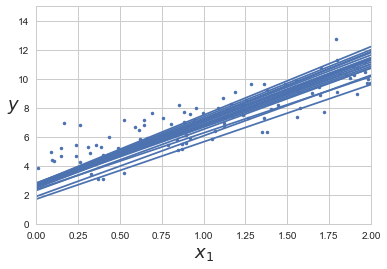

In [26]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0/ (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style) 
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown

plt.show()  

In [27]:
theta

array([[3.98038634],
       [3.21899591]])

사이킷런의 SGD방식을 사용하면 Stochastic Gradient Descent을 구현가능

In [55]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [30]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.91158135]), array([3.22067204]))

### 4.2.3 Mini-batch Gradient Descent

임의의 작은 샘플 세트에 대해 그래디언트를 계산

* 장점
  - 행령 연산에 최적화된 하드웨어(GPU)를 사용해서 얻는 성능 향상
  - 미니배치 사이즈를 어느 정도 크게 하면 SGD보다 덜 불규치적으로 움직임

In [31]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [33]:
theta

array([[3.9331768 ],
       [3.25730732]])

In [34]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

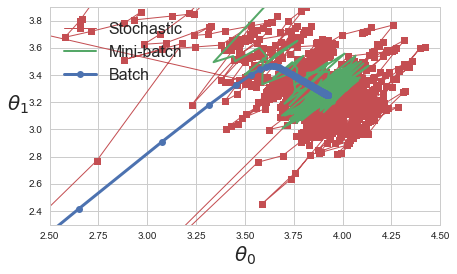

In [35]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])

plt.show()

## 4.3 Polynomial regression

In [36]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [37]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

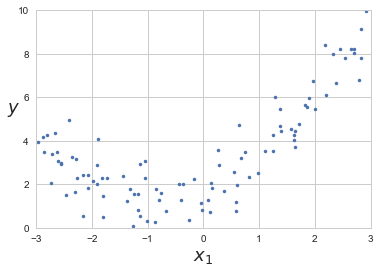

In [38]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

In [39]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [40]:
X_poly[0]

array([-0.75275929,  0.56664654])

**Observe:**
* 사이킷런의 PolynomialFeatures를 사용해 훈련 데이터를 변환  
  훈련 세트에 제곱항 특성을 추가

* X[0]은 1차항이였지만, X_ploy는 기존의 X값 뿐만 아니라 $X^2$값도 가지고 있음

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

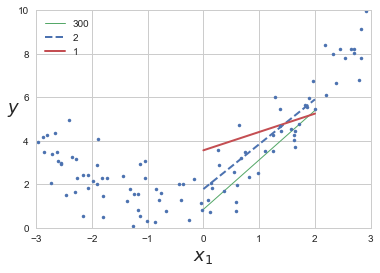

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

## 4.4 학습곡선

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14) 

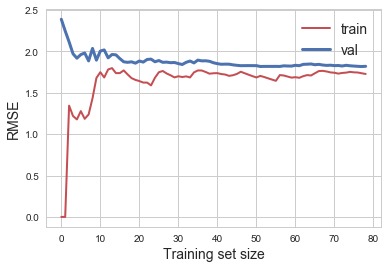

In [44]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

**Observe:**
* 이 학습곡선은 과소적합 모델의 전형적인 모습 : 더 좋은 모델이 필요
* 훈련 데이터에 대한 성능을 보면, 처음에는 오차가 0에서 시작하다가 데이터가 추가됨에 따라 오차가 점차 늘어나면서 어느 정도 평편해질때까지 오차가 계속 상승
* 검증 데이터에 대한 성능을 보면, 적은 수의 훈련 샘플로 훈련될때는 일반화 될 수 없어서 검증 오차가 매우 크다가 데이터가 추가됨에 따라 검증 오차가 천천히 감소


* 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있음

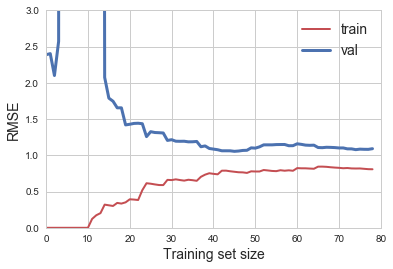

In [45]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown

plt.show() 

**Observe:**
* 훈련 데이터의 오차가 선형회귀 모델보다 훨씬 낮다.
* 두 곡선 사이에 공간이 있다 : 훈련 데이터의 성능이 검증 데이터보다 낫다는 뜻이고, 과대적합 모델의 특징이다. 더 많은 훈련 데이터를 추가할 필요가 있다.


* 과대적합 모델을 개선하는 한 가지 방법은 검증 오차가 훈련 오차에 근접할때까지 더 많은 훈련 데이터를 추가 하는 것

## 4.5 규제가 있는 선형 모델

과대적합을 감소시키는 좋은 방법은 **모델을 규제하는 것**  

선형회귀모델에서는 모델의 가중치( weight, $\theta$ )를 제한함으로써 규제를 가함  
  : 비용함수에 규제항이 추가됨

### 4.5.1 릿지 회귀

\begin{eqnarray}
\text{cost} 
&=& \sum e_i^2 + \lambda \sum w_i^2
&=& \text{RSS} + \text{alpha} \sum w_i^2
\end{eqnarray}

λ 는 기존의 잔차 제곱합과 추가적 제약 조건의 비중을 조절하기 위한 하이퍼 모수(hyper parameter)이다.   

λ가 크면 정규화 정도가 커지고 가중치의 값들이 작아진다.  
(λ가 많이 커지면 가중치가 거의 0에 가까워짐. 데이터 평균을 지나느 수평선이 됨)   

λ가 작아지면 정규화 정도가 작아지며, λ 가 0이 되면 일반적인 선형 회귀 모형이 된다.

규제항은 $l_2$Norm의 제곱을 활용

In [46]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [49]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

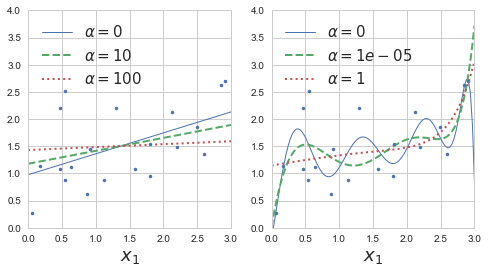

In [50]:
from sklearn.linear_model import Ridge

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

In [53]:
# 정규방정식을 이용한 Ridge 회귀
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

**Note:**  
릿지 회귀의 정규방정식
$$\theta = (X^T\cdot{X}+\lambda A)^{-1}\cdot{X^T}\cdot{y}$$

안드레 루이 숄레스키의 행렬분해를 사용하여 정규방정식을 변형한 방정식을 사용

In [57]:
# 확률적 경사 하강법을 사용
sgd_reg = SGDRegressor(max_iter=5, penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.12503999])

In [58]:
# saga는 SGD의 변종
ridge_reg = Ridge(alpha=1, solver="saga")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072345]])

### 4.5.2 라쏘 회귀

$$0.5 \times \text{RSS}/N + \text{alpha} \sum |w_i|$$

규제항은 $l_1$Norm의 제곱을 활용

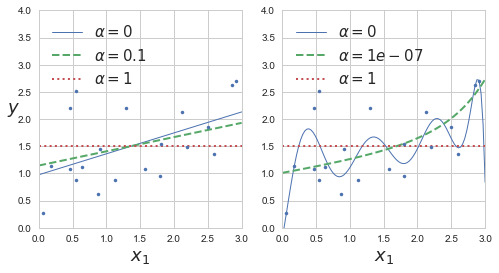

In [59]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)


plt.show()

**Note:**
* 라쏘의 중요한 특징은 덜 중요한 특성의 가중치를 완전히 제거하려고 한다.
* 라쏘 모델은 자동으로 특성 선택을 하고 희소모델을 만든다.

In [60]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

**Note:**
* 릿지 모형은 가중치 계수를 한꺼번에 축소시키는데 반해  
  랏소 모형은 일부 가중치 계수가 먼저 0으로 수렴하는 특성이 있다.

In [63]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# 편향은 무시
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

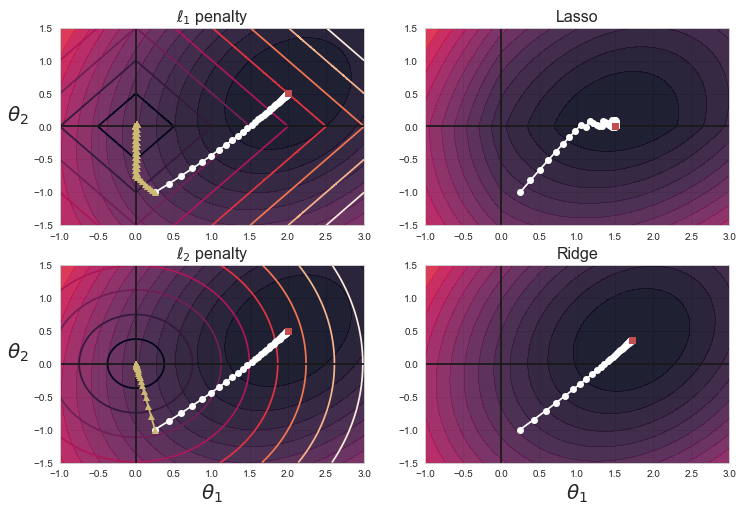

In [64]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0, labelpad=15)
    if i == 1: plt.xlabel(r"$\theta_1$", fontsize=20)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1: plt.xlabel(r"$\theta_1$", fontsize=20)


plt.show()

### 4.5.3 엘라스틱넷

\begin{eqnarray}
\text{cost} 
&=& \sum e_i^2 + r\cdot{a} \sum | w_i | + \frac{1-r}{2}\cdot{a} \sum w_i^2
\end{eqnarray}

l1_ratio가 혼합비율 r이다.  
r=1이면, 라쏘회귀와 같고, r=0이면 릿지회귀와 같다.

In [61]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 4.5.4 조기종료

In [65]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


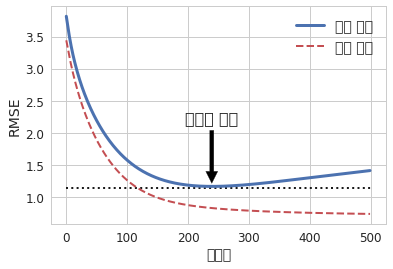

In [68]:
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('최선의 모델',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="훈련 세트")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("에포크", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

**Note:**
* 에포크가 진행됨에 따라 훈련 세트에 대한 예측에러와 검증 세트에 대한 예측에러가 줄어든다.  
  그러나 잠시 후 감소하던 검증에러가 멈추었다가 다시 상승  
  : 모델이 훈련 데이터에 과대적합되기 시작했다는 것을 의미

**조기종류 구현 코드**

In [69]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 이어서 학습합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [70]:
best_epoch, best_model

(239, SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', max_iter=1, n_iter=None, penalty=None,
        power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
        warm_start=True))